# **Deep Learning - Redes Recorrentes**

> editando




In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import BackupAndRestore
from keras.models import load_model

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Pré-Processamento - Organização dos dados
1
### Verificando o dataset

In [3]:
sns.set(style="darkgrid", font_scale=1.5)

In [4]:
df = pd.read_csv("milk.csv", parse_dates=["Date"], index_col="Date")
df.shape

(25925, 9)

In [5]:
df.head()

,AnEar,lactation,dim,milk_production,MilkShif,Cond,Dur,Peak,dim2
Date,,,,,,,,,
2023-01-09,123,4,1,11.5,11.50,5.420,276.0,6.7,1
2023-01-10,123,4,2,48.4,24.20,4.945,384.0,15.0,2
2023-01-11,123,4,3,66.4,33.20,5.060,672.0,15.5,3
2023-01-12,123,4,4,57.1,28.55,4.940,354.0,16.4,4
2023-01-13,123,4,5,78.5,39.25,5.055,396.0,17.0,5


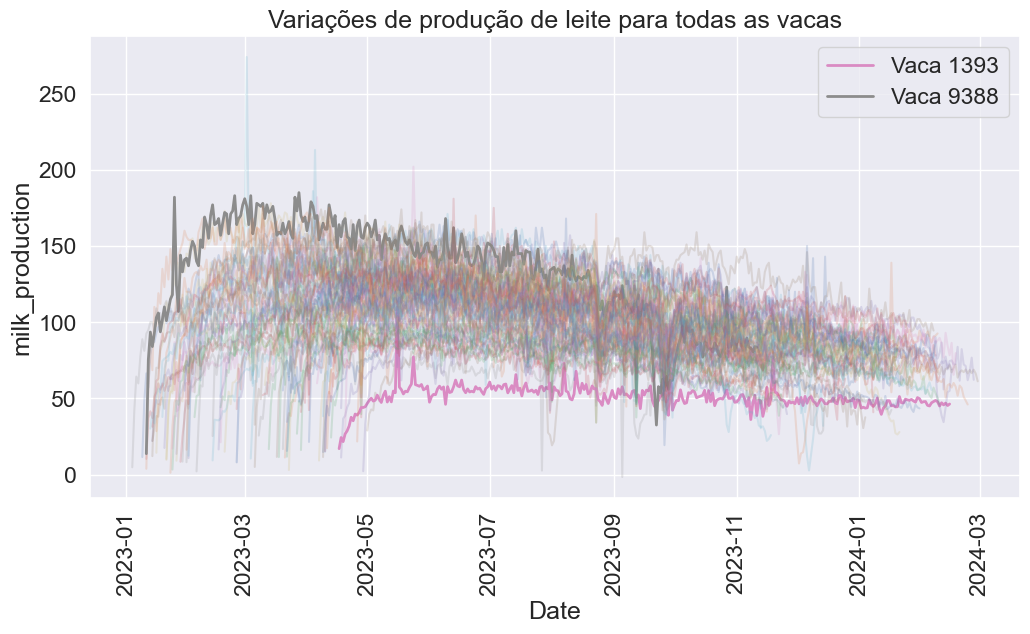

In [5]:
plt.figure(figsize=(12, 6))

# Agrupar os dados pelo identificador único da vaca e calcular a média da produção de leite para cada vaca
producao_media_por_vaca = df.groupby('AnEar')['milk_production'].mean()

# Identificar a vaca que menos produziu e a que mais produziu
vaca_menos_produziu = producao_media_por_vaca.idxmin()
vaca_mais_produziu = producao_media_por_vaca.idxmax()

for vaca, dados_vaca in df.groupby('AnEar'):
    if vaca == vaca_menos_produziu or vaca == vaca_mais_produziu:
        # Espessura maior para a vaca que menos produziu e a que mais produziu
        sns.lineplot(x=dados_vaca.index, y="milk_production", data=dados_vaca, label=f"Vaca {vaca}", linewidth=2)
    else:
        sns.lineplot(x=dados_vaca.index, y="milk_production", data=dados_vaca, alpha=0.2)


plt.title("Variações de produção de leite para todas as vacas")
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25925 entries, 2023-01-09 to 2023-12-17
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AnEar            25925 non-null  int64  
 1   lactation        25925 non-null  int64  
 2   dim              25925 non-null  int64  
 3   milk_production  25849 non-null  float64
 4   MilkShif         25849 non-null  float64
 5   Cond             25846 non-null  float64
 6   Dur              25925 non-null  float64
 7   Peak             25846 non-null  float64
 8   dim2             25925 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 2.0 MB


In [7]:
df['AnEar'].value_counts().unique() #todos tem 305 datas

array([305], dtype=int64)

In [8]:
df.nunique()

AnEar                85
lactation             8
dim                 305
milk_production     820
MilkShif           1751
Cond                721
Dur                 387
Peak                249
dim2                305
dtype: int64

In [9]:
(df[df[df.columns] == 0]).count()

AnEar               0
lactation           0
dim                 0
milk_production     0
MilkShif            0
Cond               20
Dur                80
Peak                4
dim2                0
dtype: int64

### Verificando se há descontinuação das datas

In [10]:
# Calculando a diferença entre datas
intervalo = df.iloc[0:305]

# Calculando a diferença entre datas nesse intervalo
diff_dates = intervalo.index.to_series().diff()

# Verificando se há alguma diferença maior que um dia
has_gaps = (diff_dates > pd.Timedelta(days=1)).any()


if has_gaps:
    print("Existem lacunas nas datas do índice.")
else:
    print("As datas do índice estão em série contínua.")
dates_with_gaps = intervalo.index[diff_dates > pd.Timedelta(days=1)]
# print(diff_dates)
# diff_dates.unique()
diff_dates.value_counts()

Existem lacunas nas datas do índice.


Date
1 days     301
2 days       2
-1 days      1
Name: count, dtype: int64

In [11]:
desired_diff = pd.Timedelta(days=2)
desired_diff_indices = diff_dates[diff_dates == desired_diff].index

# Imprimindo os índices onde a diferença é igual a 1 dia
print("\nÍndices onde a diferença é igual a 2 dia:")
print(desired_diff_indices)


Índices onde a diferença é igual a 2 dia:
DatetimeIndex(['2023-03-01', '2023-03-02'], dtype='datetime64[ns]', name='Date', freq=None)


In [12]:
intervalo.loc[['2023-02-28','2023-03-01', '2023-03-02','2023-03-03']]

,AnEar,lactation,dim,milk_production,MilkShif,Cond,Dur,Peak,dim2
Date,,,,,,,,,
2023-02-28,123,4,52,137.0,68.65,4.970,654.0,17.9,52
2023-03-01,123,4,51,128.0,63.80,4.900,588.0,17.9,51
2023-03-02,123,4,53,129.0,64.60,4.840,582.0,17.3,53
2023-03-03,123,4,54,122.0,61.10,4.735,600.0,17.9,54


Portanto não há descontinuação na série, só o normal de fevereiro

In [13]:
df.index.unique()

DatetimeIndex(['2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
               '2023-01-17', '2023-01-18',
               ...
               '2024-02-27', '2024-02-28', '2024-02-29', '2023-01-02',
               '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06',
               '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', name='Date', length=424, freq=None)

###  Nulos por vaca

#### Apenas coluna que interessa

In [14]:
df2 = df[["AnEar", "milk_production"]]
df2

,AnEar,milk_production
Date,,
2023-01-09,123,11.5
2023-01-10,123,48.4
2023-01-11,123,66.4
2023-01-12,123,57.1
2023-01-13,123,78.5
...,...,...
2023-12-13,9977,72.8
2023-12-14,9977,73.0
2023-12-15,9977,70.9


In [15]:
df2.describe()

,AnEar,milk_production
count,25925.000000,25849.000000
mean,7714.105882,101.949700
std,3298.280379,25.640615
min,123.000000,-1.600000
25%,8393.000000,84.000000
50%,9188.000000,101.000000
75%,9892.000000,120.000000
max,9977.000000,274.000000


In [16]:
# Agrupar os dados pelo identificador da vaca
grupos_vaca = df2.groupby('AnEar')
contagem_vacas_nulos =0
# Iterar sobre cada grupo e imprimir os valores nulos para cada vaca
for vaca, dados_vaca in grupos_vaca:
    print("Vaca:", vaca)
    nulos_vaca = dados_vaca[dados_vaca.isnull().any(axis=1)]
    if not nulos_vaca.empty:
        print("Valores nulos:")
        print(nulos_vaca)
        contagem_vacas_nulos += 1
    else:
        print("Nenhum valor nulo para esta vaca.")
    print()
print("Total de vacas com valores nulos:", contagem_vacas_nulos)

Vaca: 123
Nenhum valor nulo para esta vaca.

Vaca: 1009
Nenhum valor nulo para esta vaca.

Vaca: 1017
Nenhum valor nulo para esta vaca.

Vaca: 1209
Nenhum valor nulo para esta vaca.

Vaca: 1218
Nenhum valor nulo para esta vaca.

Vaca: 1242
Nenhum valor nulo para esta vaca.

Vaca: 1243
Nenhum valor nulo para esta vaca.

Vaca: 1275
Nenhum valor nulo para esta vaca.

Vaca: 1280
Nenhum valor nulo para esta vaca.

Vaca: 1305
Nenhum valor nulo para esta vaca.

Vaca: 1327
Nenhum valor nulo para esta vaca.

Vaca: 1329
Nenhum valor nulo para esta vaca.

Vaca: 1341
Nenhum valor nulo para esta vaca.

Vaca: 1362
Nenhum valor nulo para esta vaca.

Vaca: 1368
Nenhum valor nulo para esta vaca.

Vaca: 1387
Nenhum valor nulo para esta vaca.

Vaca: 1393
Nenhum valor nulo para esta vaca.

Vaca: 7761
Valores nulos:
            AnEar  milk_production
Date                              
2023-03-19   7761              NaN

Vaca: 8064
Valores nulos:
            AnEar  milk_production
Date                      

Ou seja, a Vaca: 8732 tem quse todos os nulos

### Verificando valores negativos

In [17]:
(df2[df2['milk_production'] < 0])

,AnEar,milk_production
Date,,
2023-09-05,9549,-1.6


### Preenchendo nulos e o negativo com o proximo

In [18]:
def preencher_nulos_com_proximo_valor_grupo(grupo):
    # if grupo.name == 8732:
    #     return grupo
    # else:
        return grupo.mask(grupo < 0).fillna(method='bfill')

# Aplicar a função a cada grupo de vaca e obter o DataFrame preenchido
df2_preenchido = grupos_vaca.apply(preencher_nulos_com_proximo_valor_grupo)

# Verificar se os valores nulos foram preenchidos corretamente
print("Valores nulos após o preenchimento:")
print(df2_preenchido[df2_preenchido.isnull().any(axis=1)])



Valores nulos após o preenchimento:
Empty DataFrame
Columns: [AnEar, milk_production]
Index: []


In [19]:
df2_preenchido = df2_preenchido.droplevel(level='AnEar')
df2_preenchido

,AnEar,milk_production
Date,,
2023-01-09,123,11.5
2023-01-10,123,48.4
2023-01-11,123,66.4
2023-01-12,123,57.1
2023-01-13,123,78.5
...,...,...
2023-12-13,9977,72.8
2023-12-14,9977,73.0
2023-12-15,9977,70.9


In [20]:
df2_preenchido[df2_preenchido['AnEar'] == 8732][20:50]

,AnEar,milk_production
Date,,
2023-01-22,8732,50.9
2023-01-23,8732,50.9
2023-01-24,8732,50.9
2023-01-25,8732,50.9
2023-01-26,8732,50.9
2023-01-27,8732,50.9
2023-01-28,8732,50.9
2023-01-29,8732,50.9
2023-01-30,8732,50.9


In [21]:
df2_preenchido.isnull().sum()

AnEar              0
milk_production    0
dtype: int64

In [22]:
df2_preenchido.shape

(25925, 2)

## Pré-Processamento - Preparação para o treino

### Tamanho da Janela Deslizante

In [23]:
# Comprimento das séries temporais
#length = 50
length = 20
#length = 5

### Embaralhando as séries antes de separar os dados

In [24]:
from sklearn.utils import shuffle

ids = df2_preenchido['AnEar'].unique()
ids

ids = shuffle(ids, random_state=10)
df2_new = df2_preenchido.set_index("AnEar").loc[ids].reset_index()
ids

### Separando  as janelas

In [61]:
def windowing(dataframe: pd.DataFrame, length: int, key: str , shuffled=False):
    '''
    ### Parameters
    dataframe: DataFrame object.
    length: Sliding window size.
    key: DataFrame column name to group series.
    shuffle: Shuffle series previous to separating windows.
    '''
    from sklearn.utils import shuffle

    spv = {}
    ids = dataframe[key].unique()

    if shuffled:
        ids = shuffle(ids, random_state=10)
        dataframe = dataframe.set_index(key).loc[ids].reset_index()

    # Agrupando os dados por 'AnEar' e iterando sobre cada grupo
    for vaca_numero, vaca_grupo in dataframe.groupby(key, sort=False):
        data = vaca_grupo.iloc[:,1]
        hist = []
        target = []

        # Criando a história e o alvo para cada ponto possível dentro do grupo
        for i in range(len(data) - length):
            x = data.iloc[i:i+length]
            y = data.iloc[i+length]  # alvo

            hist.append(x)
            target.append(y)

    # Armazenando as séries e alvos no dicionário
        spv[vaca_numero] = {'hist': hist,
                            'target': target
                            }

    aspa = np.array([value['hist']
                     for value in
                     spv.values()]
                     )
    
    atpa = np.array([value['target']
                     for value in
                     spv.values()]
                     )
    
    atpa = atpa.reshape(atpa.shape[0],
                        atpa.shape[1],
                        1
                        )


    return aspa, atpa

In [64]:
arrays_series_por_animal, arrays_targets_por_animal = windowing(dataframe=df2_preenchido,
                                                                length=20,
                                                                key='AnEar',
                                                                shuffled=True
                                                                )

In [65]:
arrays_series_por_animal[0][0]

array([11.2, 36.7, 38.6, 44.2, 47. , 59.6, 52.7, 53.9, 54.6, 61.1, 66.7,
       63.6, 62.8, 65. , 67.3, 67.4, 70.6, 69.2, 72. , 74.9])

In [25]:
# Dicionário para armazenar as séries e alvos por vaca
series_por_vaca = {}

# Agrupando os dados por 'AnEar' e iterando sobre cada grupo
for vaca_numero, vaca_grupo in df2_preenchido.groupby("AnEar", sort=False):
    data = vaca_grupo.iloc[:,1]

    hist = []
    target = []

    # Criando a história e o alvo para cada ponto possível dentro do grupo
    for i in range(len(data) - length):
        x = data.iloc[i:i+length]
        y = data.iloc[i+length]  # alvo

        hist.append(x)
        target.append(y)

    # Armazenando as séries e alvos no dicionário
    series_por_vaca[vaca_numero] = {'hist': hist, 'target': target}

# Verificando se há 85 séries distintas
print("Total de vacas com séries criadas:", len(series_por_vaca))


Total de vacas com séries criadas: 85


In [26]:
series_por_vaca.keys()

dict_keys([123, 1009, 1017, 1209, 1218, 1242, 1243, 1275, 1280, 1305, 1327, 1329, 1341, 1362, 1368, 1387, 1393, 7761, 8064, 8334, 8385, 8393, 8434, 8435, 8438, 8509, 8581, 8667, 8723, 8732, 8741, 8932, 8947, 8996, 9005, 9066, 9069, 9078, 9081, 9090, 9101, 9149, 9188, 9207, 9284, 9346, 9363, 9388, 9389, 9431, 9463, 9464, 9478, 9487, 9488, 9525, 9529, 9549, 9558, 9562, 9583, 9885, 9891, 9892, 9894, 9908, 9909, 9910, 9917, 9918, 9920, 9922, 9926, 9928, 9929, 9933, 9939, 9943, 9944, 9946, 9951, 9961, 9967, 9968, 9977])

In [27]:
series_por_vaca[123]['hist'][0]

Date
2023-01-09     11.5
2023-01-10     48.4
2023-01-11     66.4
2023-01-12     57.1
2023-01-13     78.5
2023-01-14     87.5
2023-01-15     87.0
2023-01-16     93.0
2023-01-17     96.9
2023-01-18     93.3
2023-01-19     99.4
2023-01-20    106.0
2023-01-21     99.3
2023-01-22    101.0
2023-01-23    109.0
2023-01-24    101.0
2023-01-25    106.0
2023-01-26    105.0
2023-01-27    113.0
2023-01-28    109.0
Name: milk_production, dtype: float64

In [28]:
arrays_series_por_animal = np.array([value['hist'] for value in series_por_vaca.values()])
arrays_targets_por_animal = np.array([value['target'] for value in series_por_vaca.values()])

# Imprimindo as séries para os primeiros 3 animais
print("Arrays de séries por animal:")
for i, (hist, target) in enumerate(zip(arrays_series_por_animal[:3], arrays_targets_por_animal[:3])):
    vaca_atual = list(series_por_vaca.keys())[i]
    print(f"Série para o animal {vaca_atual}:")
    print(hist)
    print(hist.shape)
    print(f"Target: {target}")
    print(target.shape)
    print("---- Fim da série ----")

Arrays de séries por animal:
Série para o animal 123:
[[ 11.5  48.4  66.4 ... 105.  113.  109. ]
 [ 48.4  66.4  57.1 ... 113.  109.  116. ]
 [ 66.4  57.1  78.5 ... 109.  116.  109. ]
 ...
 [ 69.8  54.6  54.6 ...  52.5  49.3  46. ]
 [ 54.6  54.6  60.8 ...  49.3  46.   49.6]
 [ 54.6  60.8  61.2 ...  46.   49.6  46.6]]
(285, 20)
Target: [116.  109.  111.  122.  119.  114.  123.  130.  134.   61.8 116.  121.
 107.  105.  112.  119.  116.  108.  111.  118.  119.  128.  121.  119.
 118.  118.  119.  122.  121.  125.  128.  137.  129.  122.  128.  140.
 119.  128.  130.  126.  122.  118.  129.  130.  136.  141.  141.  136.
 130.  123.  145.  134.  127.  133.  128.  133.  118.  119.  123.  127.
 140.  142.  134.  140.  136.  132.  131.  142.  136.  136.  129.  123.
 129.  134.  128.  133.  128.  133.  128.  124.  127.  130.  122.  126.
 127.  124.  130.  123.  139.  121.  116.  125.  121.  121.  120.  107.
 116.  121.  118.  119.  120.  117.  111.  117.  116.  115.  116.  113.
 113.  112.  122

In [29]:
arrays_series_por_animal.shape

(85, 285, 20)

In [30]:
print(arrays_series_por_animal[0][0]) #primeira instancia do primeiro animal
arrays_series_por_animal[0].shape

[ 11.5  48.4  66.4  57.1  78.5  87.5  87.   93.   96.9  93.3  99.4 106.
  99.3 101.  109.  101.  106.  105.  113.  109. ]


(285, 20)

In [31]:
print(arrays_series_por_animal[0][arrays_series_por_animal.shape[1]-1])# ultima instancia do primeiro animal
arrays_series_por_animal[0][0].shape

[54.6 60.8 61.2 54.1 63.8 58.9 55.  53.8 53.3 52.3 51.7 50.2 47.8 46.7
 50.9 52.5 49.3 46.  49.6 46.6]


(20,)

In [32]:
arrays_targets_por_animal[0][arrays_series_por_animal.shape[1]-1]

47.8

In [33]:
arrays_targets_por_animal[0][0]

116.0

In [34]:
print(arrays_series_por_animal[0][0])

[ 11.5  48.4  66.4  57.1  78.5  87.5  87.   93.   96.9  93.3  99.4 106.
  99.3 101.  109.  101.  106.  105.  113.  109. ]


In [35]:
print(len(arrays_series_por_animal))
print(len(arrays_targets_por_animal))
print(arrays_series_por_animal[0][0][length-1]) #  length-1 acessa o último elemento dessa série.

85
85
109.0


In [36]:
arrays_series_por_animal[0].shape

(285, 20)

In [37]:
arrays_targets_por_animal.shape

(85, 285)

In [38]:
arrays_targets_por_animal[0].shape

(285,)

### Reshape target

In [39]:
#reshaped_targets = arrays_targets_por_animal.reshape(85, 255, 1)
#reshaped_targets = arrays_targets_por_animal.reshape(85, 285, 1)
#reshaped_targets = arrays_targets_por_animal.reshape(85, 300, 1)

reshaped_targets = arrays_targets_por_animal.reshape(85,
                                                     arrays_targets_por_animal.shape[1],
                                                     1
                                                     )


# Verificando a nova forma
print(reshaped_targets.shape)

(85, 285, 1)


In [40]:
reshaped_targets[0].shape

(285, 1)

### Separação



*   Divisão da coleção entre treino (60%), validação (20%) e teste (20%)






Assuma que as 85 séries (correspondentes aos 85 animais) são independentes e identicamente distribuídas, ou seja, algumas series serão usadas para treino e outras para teste e validação

In [41]:

# Concatenar todas as séries em um único array
X_all = np.concatenate(arrays_series_por_animal, axis=0)
y_all = np.concatenate(reshaped_targets, axis=0)

total_samples_all = X_all.shape[0]

train_end = int(total_samples_all * 0.6)
val_end = int(total_samples_all * 0.8)


X_train_all = X_all[:train_end]
X_val_all = X_all[train_end:val_end]
X_test_all = X_all[val_end:]

y_train_all = y_all[:train_end]
y_val_all = y_all[train_end:val_end]
y_test_all = y_all[val_end:]


print("X_train_all shape:", X_train_all.shape)
print("X_val_all shape:", X_val_all.shape)
print("X_test_all shape:", X_test_all.shape)
print("y_train_all shape:", y_train_all.shape)
print("y_val_all shape:", y_val_all.shape)
print("y_test_all shape:", y_test_all.shape)


X_train_all shape: (14535, 20)
X_val_all shape: (4845, 20)
X_test_all shape: (4845, 20)
y_train_all shape: (14535, 1)
y_val_all shape: (4845, 1)
y_test_all shape: (4845, 1)


In [42]:
X_all.shape

(24225, 20)

### Normalização

In [43]:
sc = MinMaxScaler()
#sc = StandardScaler()
sc.fit(X_train_all)
X_train = sc.transform(X_train_all)
X_val = sc.transform(X_val_all)
X_test = sc.transform(X_test_all)


X_train = X_train.reshape((len(X_train), length, 1)) #array 3d (entrada do LSTM). A terceira dimensão tem apenas 1 feature.
X_val = X_val.reshape((len(X_val), length, 1))
X_test = X_test.reshape((len(X_test), length, 1))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

sc.fit(y_train_all)
y_train = sc.transform(y_train_all)
y_val = sc.transform(y_val_all)

y_test = sc.transform(y_test_all)

(14535, 20, 1)
(4845, 20, 1)
(4845, 20, 1)


## Construindo o modelo

Redes recorrentes são modelos poderosos para tratar sequências, pois eles mantêm o estado interno sobre as variações anteriores. Tais redes requerem uma matriz 3d com formato: (num_exemplos_treino, timesteps, input_dim).

Vamos construir um modelo usando timesteps=20, 50 e 5 valores anteriores para prever o próximo valor. Como estamos usando apenas uma variável, input_dim=1.

### Construindo a rede neural

In [44]:
model = Sequential()

#model.add(SimpleRNN(25, return_sequences=True, input_shape=(length,1)))
model.add(SimpleRNN(25, input_shape=(length,1)))

model.add(Dense(1))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 25)                675       
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


Criamos um modelo com 1 camada de RNN e 1 camada densa de saída. Compilando e treinando o método...

### Para salvar o treinamento e modelo

In [45]:
path = './models/milk_0_val'

restore = BackupAndRestore(backup_dir=path+"/backup")

save_model = ModelCheckpoint(filepath=path+'/milk_weights.hdf5',
                             verbose=1,
                             save_best_only=True
                             )

In [46]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae']
              )

In [49]:
X_train.shape

(14535, 20, 1)

### Treinando o modelo

In [47]:
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),  batch_size=32,  callbacks=[checkpoint])

history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    shuffle=True,
                    callbacks=[restore, save_model]
                    )

Epoch 1/30


455/455 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0357
Epoch 1: val_loss improved from inf to 0.00127, saving model to ./models/milk_0_val\milk_weights.hdf5
455/455 [==============================] - 10s 19ms/step - loss: 0.0034 - mae: 0.0357 - val_loss: 0.0013 - val_mae: 0.0252
Epoch 2/30
454/455 [============================>.] - ETA: 0s - loss: 0.0013 - mae: 0.0247
Epoch 2: val_loss improved from 0.00127 to 0.00105, saving model to ./models/milk_0_val\milk_weights.hdf5
455/455 [==============================] - 9s 19ms/step - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0010 - val_mae: 0.0230
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0226
Epoch 3: val_loss improved from 0.00105 to 0.00085, saving model to ./models/milk_0_val\milk_weights.hdf5
455/455 [==============================] - 9s 20ms/step - loss: 0.0011 - mae: 0.0226 - val_loss: 8.4561e-04 - val_mae: 0.0206
Epoch 4/30
453/455 [============================>.] -

### Salvando o histórico do treinamento

In [48]:
pd.DataFrame(history.history).to_csv(path+'/treinamento.csv')

## Carregando o modelo salvo

In [52]:
fm_model0 = load_model('./models/milk_0'+'/milk_weights.hdf5')
fm_model5 = load_model('./models/milk_5'+'/milk_weights.hdf5')
fm_model6 = load_model('./models/milk_6'+'/milk_weights.hdf5')
fm_model7 = load_model('./models/milk_7'+'/milk_weights.hdf5')

#fm_model.summary()

fm_model0.load_weights('./models/milk_0'+'/milk_weights.hdf5')
fm_model5.load_weights('./models/milk_5'+'/milk_weights.hdf5')
fm_model6.load_weights('./models/milk_6'+'/milk_weights.hdf5')
fm_model7.load_weights('./models/milk_7'+'/milk_weights.hdf5')

In [49]:
treinamento0 = pd.read_csv('./models/milk_0/treinamento.csv', index_col=0)
treinamento5 = pd.read_csv('./models/milk_5/treinamento.csv', index_col=0)
treinamento6 = pd.read_csv('./models/milk_6/treinamento.csv', index_col=0)
treinamento7 = pd.read_csv('./models/milk_7/treinamento.csv', index_col=0)
#treinamento01 = pd.read_csv('./models/milk_0_shuffle/treinamento.csv', index_col=0)
treinamento02 = pd.read_csv('./models/milk_0_shuffle1/treinamento.csv', index_col=0)
treinamento01 = pd.read_csv('./models/milk_0_val/treinamento.csv', index_col=0)




Vamos visualizar os erros de treino e validação:



### Comparação SimpleRNN 25x2

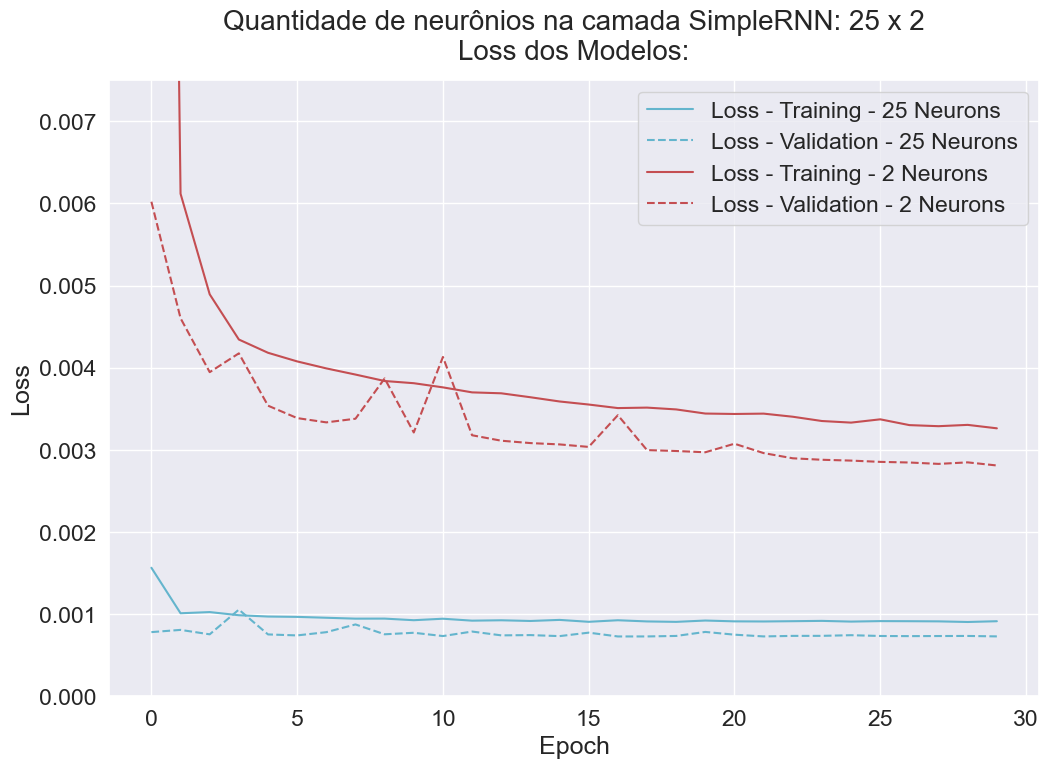

In [57]:
title = {'label':'Quantidade de neurônios na camada SimpleRNN: 25 x 2\nLoss dos Modelos:',
         'fontsize':20,
         'pad':15}

plt.figure(figsize=(12,8))
plt.plot(treinamento0.index, treinamento0['loss'], 'c')
plt.plot(treinamento0.index, treinamento0['val_loss'], 'c--')
plt.plot(treinamento6.index, treinamento5['loss'], 'r')
plt.plot(treinamento6.index, treinamento5['val_loss'], 'r--')
plt.legend(['Loss - Training - 25 Neurons ',
            'Loss - Validation - 25 Neurons',
            'Loss - Training - 2 Neurons',
            'Loss - Validation - 2 Neurons']
            )
plt.grid(True)
plt.ylim(0,0.0075)
plt.title(**title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('25x2 - LOSS.png')
plt.show()

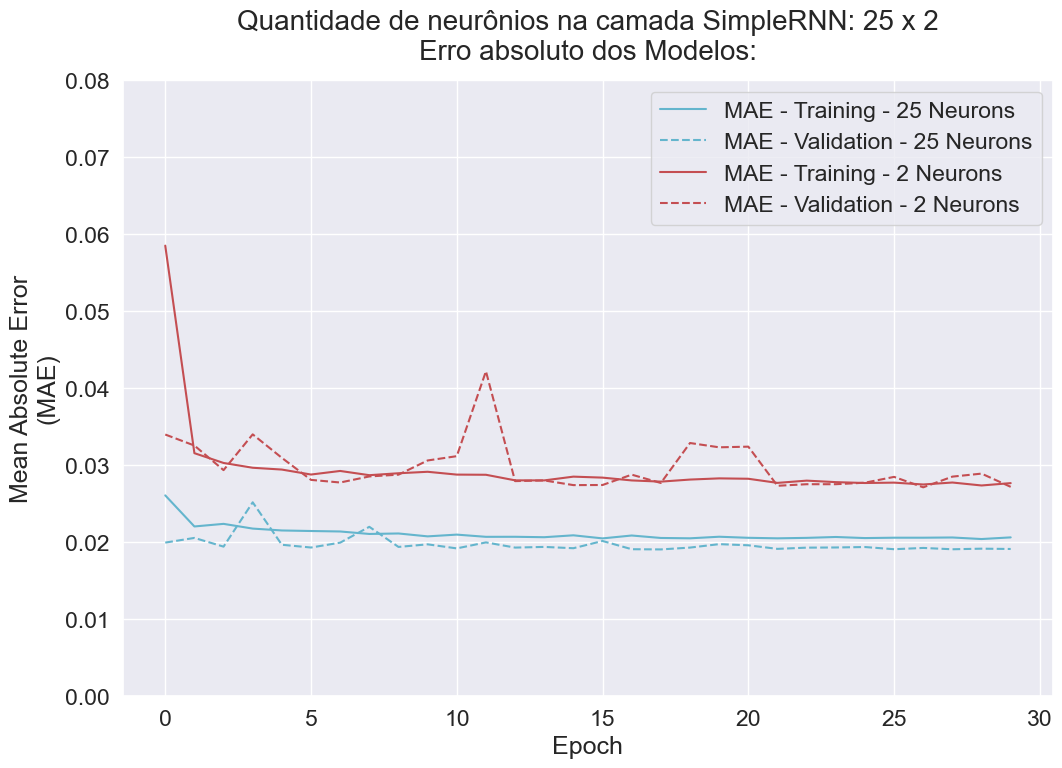

In [167]:
title = {'label':'Quantidade de neurônios na camada SimpleRNN: 25 x 2\nErro absoluto dos Modelos:',
         'fontsize':20,
         'pad': 15}

plt.figure(figsize=(12,8))
plt.plot(treinamento0.index, treinamento0['mae'], 'c')
plt.plot(treinamento0.index, treinamento0['val_mae'], 'c--')
plt.plot(treinamento01.index, treinamento01['mae'], 'r')
plt.plot(treinamento01.index, treinamento01['val_mae'], 'r--')
plt.legend(['MAE - Training - 25 Neurons ',
            'MAE - Validation - 25 Neurons',
            'MAE - Training - 2 Neurons',
            'MAE - Validation - 2 Neurons']
            )
plt.grid(True)
plt.ylim(0,0.08)
plt.title(**title)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error\n(MAE)')
plt.savefig('25x2 - MAE.png')
plt.show()



### Comparação Janela Deslizante 20x50

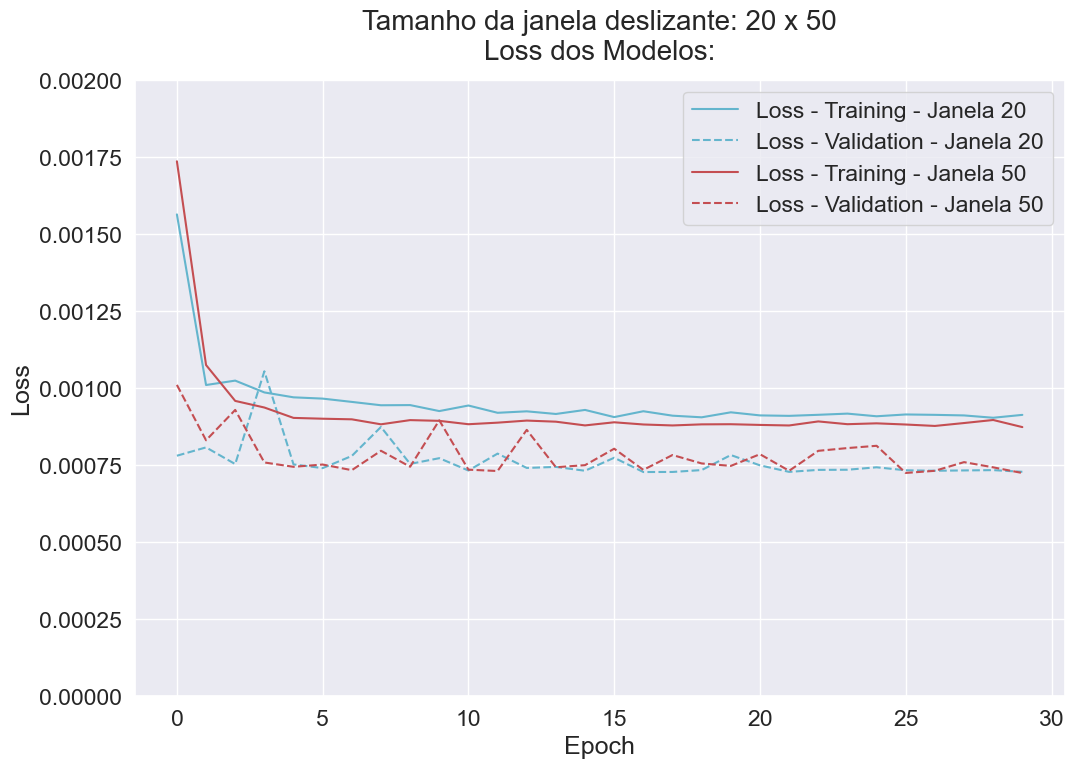

In [182]:
title = {'label':'Tamanho da janela deslizante: 20 x 50\nLoss dos Modelos:',
         'fontsize':20,
         'pad':15}

plt.figure(figsize=(12,8))
plt.plot(treinamento0.index, treinamento0['loss'], 'c')
plt.plot(treinamento0.index, treinamento0['val_loss'], 'c--')
plt.plot(treinamento6.index, treinamento6['loss'], 'r')
plt.plot(treinamento6.index, treinamento6['val_loss'], 'r--')
plt.legend(['Loss - Training - Janela 20 ',
            'Loss - Validation - Janela 20',
            'Loss - Training - Janela 50',
            'Loss - Validation - Janela 50']
            )
plt.grid(True)
plt.ylim(0,0.002)
plt.title(**title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('20x50 - LOSS.png')
plt.show()

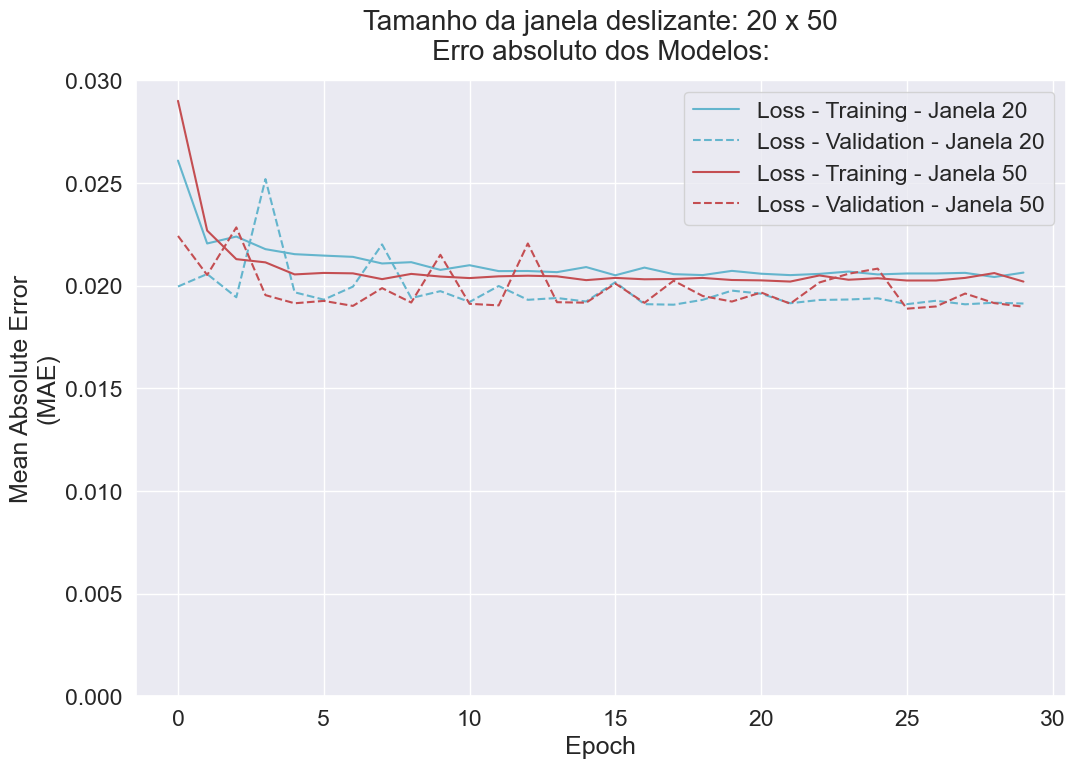

In [183]:
title = {'label':'Tamanho da janela deslizante: 20 x 50\nErro absoluto dos Modelos:',
         'fontsize':20,
         'pad': 15}

plt.figure(figsize=(12,8))
plt.plot(treinamento0.index, treinamento0['mae'], 'c')
plt.plot(treinamento0.index, treinamento0['val_mae'], 'c--')
plt.plot(treinamento6.index, treinamento6['mae'], 'r')
plt.plot(treinamento6.index, treinamento6['val_mae'], 'r--')
plt.legend(['Loss - Training - Janela 20 ',
            'Loss - Validation - Janela 20',
            'Loss - Training - Janela 50',
            'Loss - Validation - Janela 50']
            )
plt.grid(True)
plt.ylim(0,0.03)
plt.title(**title)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error\n(MAE)')
plt.savefig('20x50 - MAE.png')
plt.show()



### Comparação Janela Deslizante 20x5

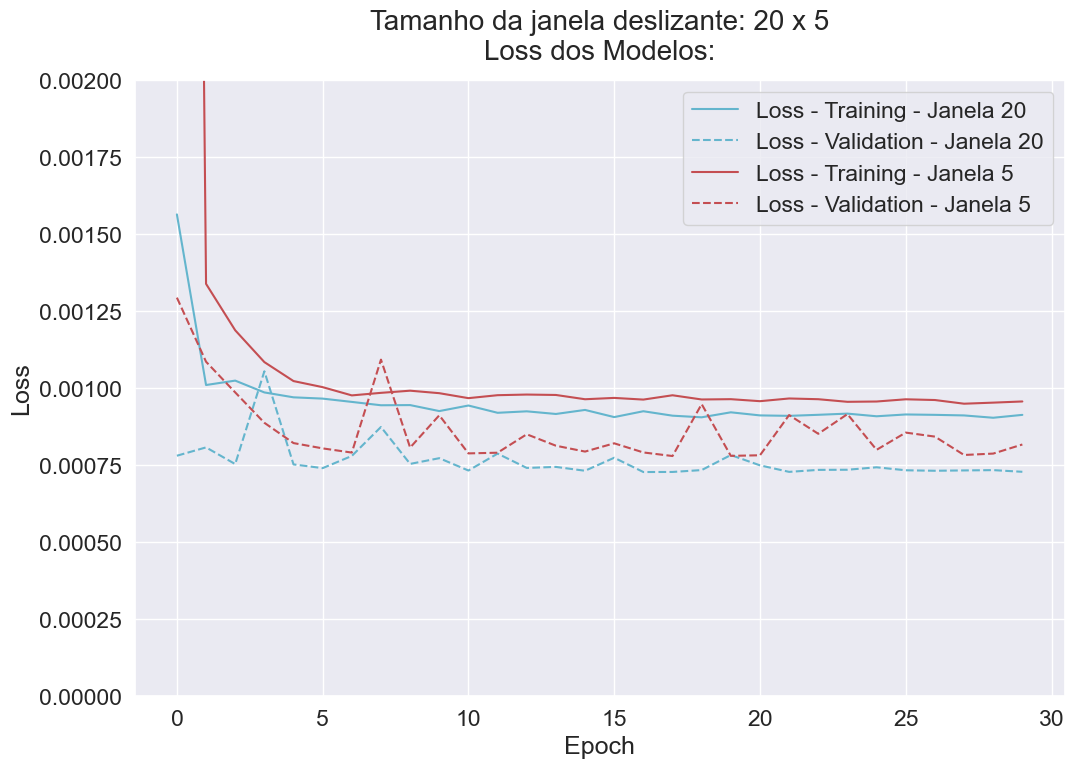

In [184]:
title = {'label':'Tamanho da janela deslizante: 20 x 5\nLoss dos Modelos:',
         'fontsize':20,
         'pad':15}

plt.figure(figsize=(12,8))
plt.plot(treinamento0.index, treinamento0['loss'], 'c')
plt.plot(treinamento0.index, treinamento0['val_loss'], 'c--')
plt.plot(treinamento7.index, treinamento7['loss'], 'r')
plt.plot(treinamento7.index, treinamento7['val_loss'], 'r--')
plt.legend(['Loss - Training - Janela 20 ',
            'Loss - Validation - Janela 20',
            'Loss - Training - Janela 5',
            'Loss - Validation - Janela 5']
            )
plt.grid(True)
plt.ylim(0,0.002)
plt.title(**title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('20x5 - LOSS.png')
plt.show()

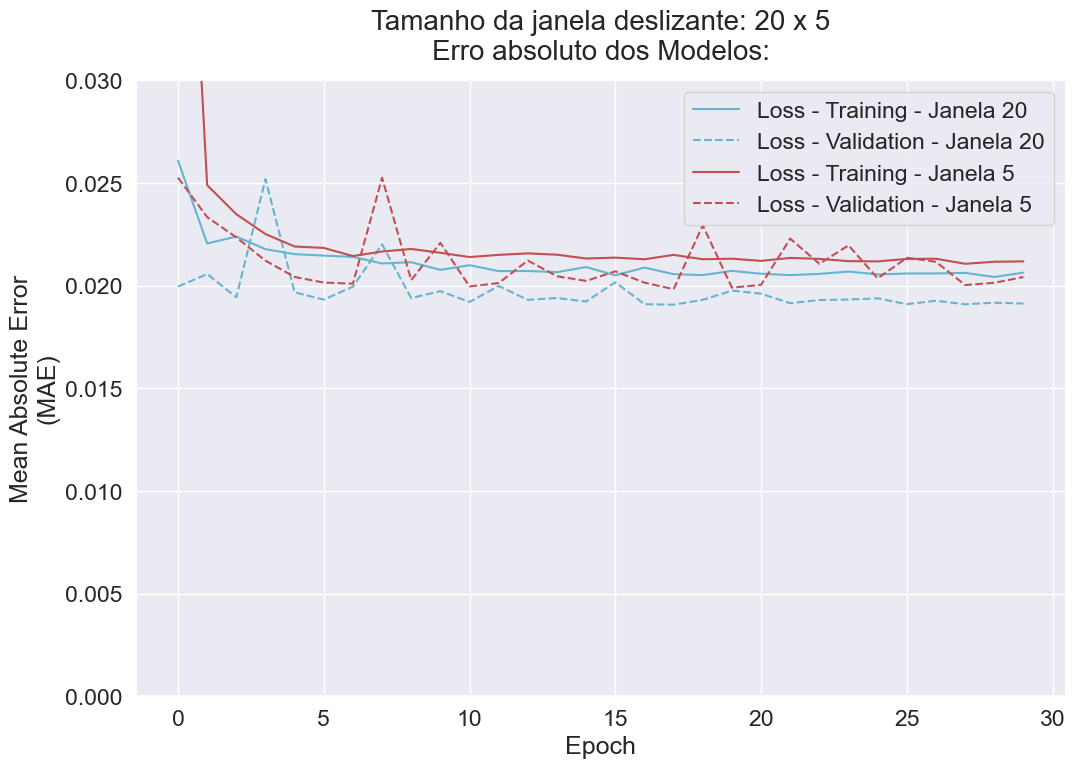

In [185]:
title = {'label':'Tamanho da janela deslizante: 20 x 5\nErro absoluto dos Modelos:',
         'fontsize':20,
         'pad': 15}

plt.figure(figsize=(12,8))
plt.plot(treinamento0.index, treinamento0['mae'], 'c')
plt.plot(treinamento0.index, treinamento0['val_mae'], 'c--')
plt.plot(treinamento7.index, treinamento7['mae'], 'r')
plt.plot(treinamento7.index, treinamento7['val_mae'], 'r--')
plt.legend(['Loss - Training - Janela 20 ',
            'Loss - Validation - Janela 20',
            'Loss - Training - Janela 5',
            'Loss - Validation - Janela 5']
            )
plt.grid(True)
plt.ylim(0,0.03)
plt.title(**title)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error\n(MAE)')
plt.savefig('20x5 - MAE.png')
plt.show()



### Comparação do Shuffle

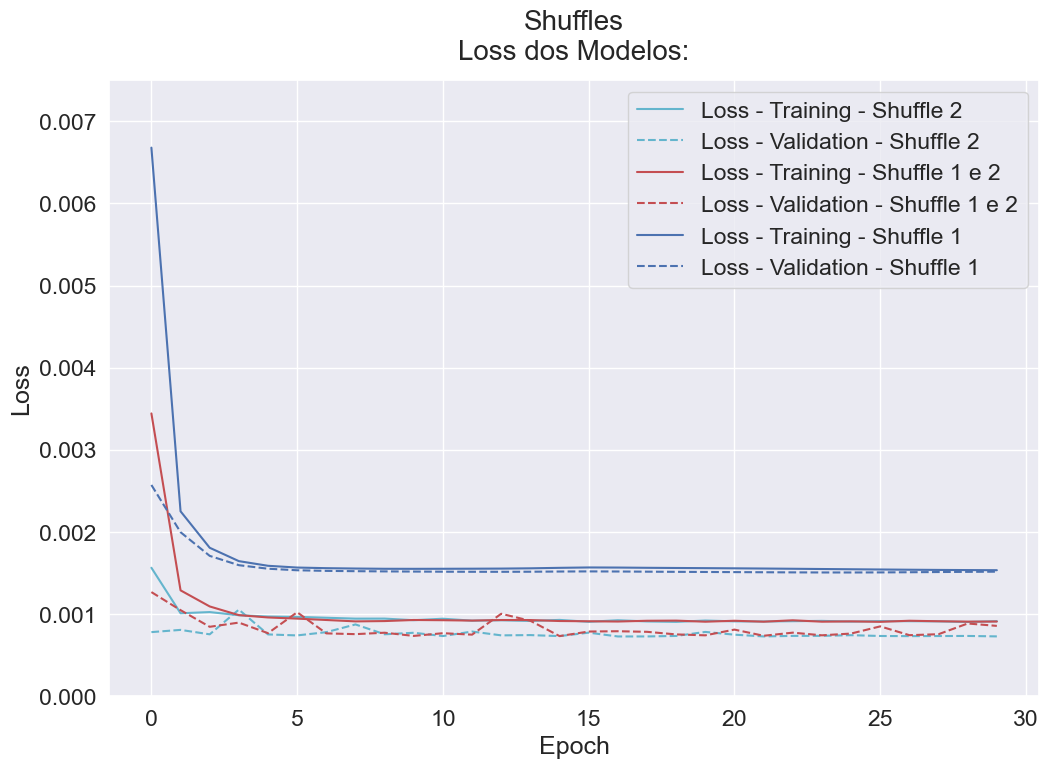

In [50]:
title = {'label':'Shuffles\nLoss dos Modelos:',
         'fontsize':20,
         'pad':15}

plt.figure(figsize=(12,8))
plt.plot(treinamento0.index, treinamento0['loss'], 'c')
plt.plot(treinamento0.index, treinamento0['val_loss'], 'c--')
plt.plot(treinamento01.index, treinamento01['loss'], 'r')
plt.plot(treinamento01.index, treinamento01['val_loss'], 'r--')
plt.plot(treinamento02.index, treinamento02['loss'], 'b')
plt.plot(treinamento02.index, treinamento02['val_loss'], 'b--')
plt.legend(['Loss - Training - Shuffle 2',
            'Loss - Validation - Shuffle 2',
            'Loss - Training - Shuffle 1 e 2',
            'Loss - Validation - Shuffle 1 e 2',
            'Loss - Training - Shuffle 1',
            'Loss - Validation - Shuffle 1']
            )
plt.grid(True)
plt.ylim(0,0.0075)
plt.title(**title)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('25x2 - LOSS.png')
plt.show()

Vamos fazer as predições:

### Fazendo as predições

In [59]:
pred = fm_model0.predict(X_test)

#print(np.hstack((pred, y_val)))


160/160 [==============================] - 1s 2ms/step


In [60]:
X_test[0].shape

(5, 1)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.title('Produção de leite')
plt.legend()
plt.savefig('./Images/Test Normalized.png')
plt.show()

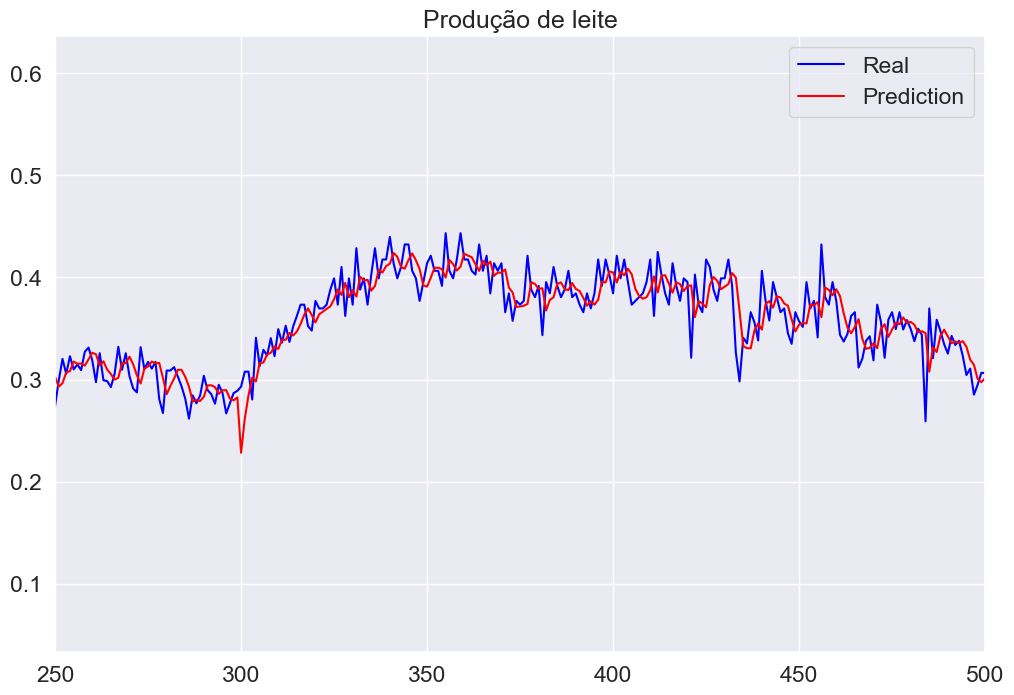

In [52]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred, color='red', label='Prediction')
plt.xlim(250,500)
plt.title('Produção de leite')
plt.legend()
plt.show()

O modelo parece estar bem ajustado. Vamos verificar o valor real (sem normalização):

In [53]:
pred_transformed = sc.inverse_transform(pred)
y_test_transformed = sc.inverse_transform(y_test)

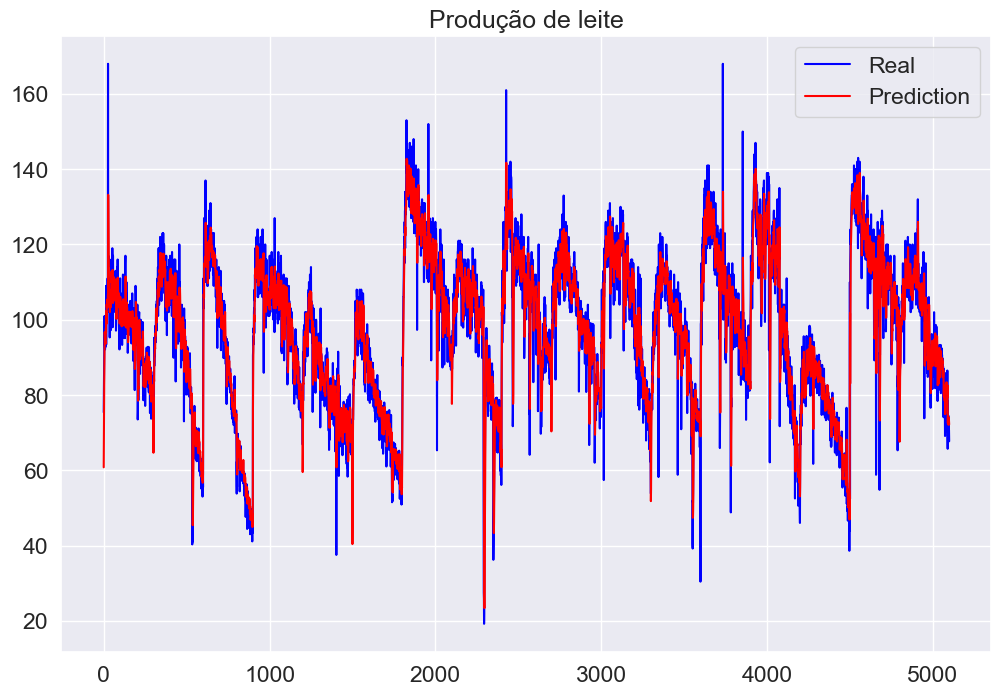

In [54]:
plt.figure(figsize=(12,8))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('Produção de leite')

plt.legend()
plt.show()

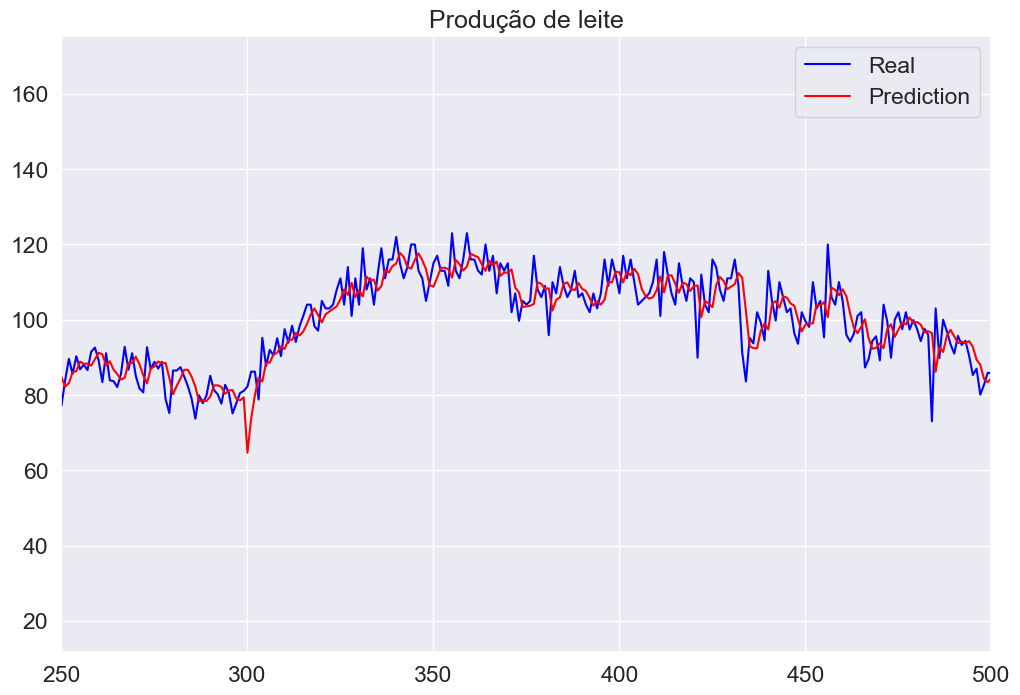

In [55]:
plt.figure(figsize=(12,8))
plt.plot(y_test_transformed, color='blue', label='Real')
plt.plot(pred_transformed, color='red', label='Prediction')
plt.title('Produção de leite')
plt.xlim(250,500)
plt.legend()
plt.show()

In [56]:
model.evaluate(X_test,y_test)

160/160 [==============================] - 1s 3ms/step - loss: 0.0960 - mae: 0.3029


[0.0959828570485115, 0.3028794229030609]